# Collaborators Whereabouts
Author: Sam Eriksen

Description: Notebook to read in collaboration list from google sheets and plot

In [1]:
import numpy as np
import pandas as pd
#import tqdm
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

Get author list information

In [2]:
spreadsheet_id = "1J-8ehKgEcpmssEZ_dGRIp5lRQCg6tDonYYG87Rv__4I"
sheet_id = "951549455"
sheet_url = f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv&gid={sheet_id}"

df = pd.read_csv(sheet_url)

cut_down_df = df.loc[4:].dropna(subset=["Unnamed: 2"])

final_info = cut_down_df[["Unnamed: 47", "Unnamed: 43", "# considered (x-check)", "PRIMARY PAGE", "Unnamed: 3"]]

final_info.columns = ["Title", "Initials", "LastName", "University", "isAuthor"]

In [3]:
final_info

,Title,Initials,LastName,University,isAuthor
6,Faculty,B. J.,Mount,Black Hills State University,TRUE
7,Undergrad,A.,Rodriguez,Black Hills State University,FALSE
9,Grad Stud,L.,Korley,Brandeis University,FALSE
10,Faculty,B.,Penning,Brandeis University,FALSE
11,Post Doc,J.J.,Wang,Brandeis University,FALSE
...,...,...,...,...,...
832,Engineer,W. T.,Emmet,Yale University,FALSE
833,Technician,T. W.,Hurteau,Yale University,FALSE
834,Grad Stud,N. A.,Larsen,Yale University,FALSE
835,Grad Stud,B. P.,Tennyson,Yale University,FALSE


Get university address information

In [4]:
spreadsheet_id = "1J-8ehKgEcpmssEZ_dGRIp5lRQCg6tDonYYG87Rv__4I"
sheet_id = "1098381277"
sheet_url = f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv&gid={sheet_id}"

df = pd.read_csv(sheet_url)

institutions = df[["SECONDARY PAGE", "Unnamed: 7"]]
institutions.columns = ["University", "Address"]
institutions = institutions.iloc[4:]
institutions = institutions.dropna(subset=['Address'])
institutions['Address'] = institutions['Address'].str.replace('GBR', 'UK')
institutions['Universities_FullName'] = institutions['University'] + ', ' + institutions['Address']
institutions['Short_Address'] = institutions['Address'].apply(lambda x: ', '.join(x.split(', ')[-2:]))
institutions['Corrected_Name'] = institutions['University'].apply(lambda x: x.split(' (')[0])
institutions['Start_Address'] = institutions['Address'].apply(lambda x: ', '.join(x.split(', ')[:2]))

Get Long and Lat

In [6]:
def get_latitude(location):
    try:
        return location.latitude
    except AttributeError:
        return None

def get_longitude(location):
    try:
        return location.longitude
    except AttributeError:
        return None
def correct_none(entry):
    long = None
    lat = None
    print(entry['Short_Address'])
    if 'Daejeon' in entry['Short_Address']:
        lat = 36.375394
        long = 127.384520
    elif '57754-1700' in entry['Short_Address']:
        lat = 44.345992
        long = -103.755154
    print(long)
    print(lat)
    return long, lat

In [7]:
# Initialize the geocoder
geolocator = Nominatim(user_agent="university_geocoder")
# To avoid hitting the service rate limits
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [8]:
institutions['location'] = institutions['University'].apply(geocode)
institutions.loc[institutions['location'].isna(), 'location'] = institutions[institutions['location'].isna()]['Corrected_Name'].apply(geocode)
institutions.loc[institutions['location'].isna(), 'location'] = institutions[institutions['location'].isna()]['Short_Address'].apply(geocode)
institutions.loc[institutions['location'].isna(), 'location'] = institutions[institutions['location'].isna()]['Address'].apply(geocode)
institutions.loc[institutions['location'].isna(), 'location'] = institutions[institutions['location'].isna()]['Start_Address'].apply(geocode)

In [9]:
institutions['longitude'] = institutions['location'].apply(get_longitude)
institutions['latitude'] = institutions['location'].apply(get_latitude)
institutions[['longitude', 'latitude']] = institutions.apply(lambda row: correct_none(row) if pd.isna(row['latitude']) else (row['longitude'], row['latitude']), axis=1, result_type='expand')

Daejeon, KOR
127.38452
36.375394


In [10]:
institutions

,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude
4,Black Hills State University,"School of Natural Sciences, 1200 University St...","Black Hills State University, School of Natura...","SD 57799-0002, USA",Black Hills State University,"School of Natural Sciences, 1200 University St...","(Black Hills State University, 1200, Universit...",-103.872854,44.498150
5,Brookhaven National Laboratory (BNL),"P.O. Box 5000, Upton, NY 11973-5000, USA","Brookhaven National Laboratory (BNL), P.O. Box...","NY 11973-5000, USA",Brookhaven National Laboratory,"P.O. Box 5000, Upton","(BNL Police, Upton Road, Brookhaven National L...",-72.887100,40.864767
6,Brandeis University,"Department of Physics, 415 South Street, Walt...","Brandeis University, Department of Physics, 4...","MA 02453, USA",Brandeis University,"Department of Physics, 415 South Street","(Brandeis University, 415, South Street, West ...",-71.258020,42.366509
7,Brown University,"Department of Physics, 182 Hope Street, Provid...","Brown University, Department of Physics, 182 H...","RI 02912-9037, USA",Brown University,"Department of Physics, 182 Hope Street","(Brown University, Eddy Street, Downtown, Prov...",-71.408801,41.818640
8,Center for Underground Physics (CUP),"IBS Center for Underground Physics 70, Yuseong...","Center for Underground Physics (CUP), IBS Cent...","Daejeon, KOR",Center for Underground Physics,"IBS Center for Underground Physics 70, Yuseong...",None,127.384520,36.375394
9,Fermi National Accelerator Laboratory (FNAL),"P.O. Box 500, Batavia, IL 60510-5011, USA","Fermi National Accelerator Laboratory (FNAL), ...","IL 60510-5011, USA",Fermi National Accelerator Laboratory,"P.O. Box 500, Batavia","(Fermi National Accelerator Laboratory, Wilson...",-88.245782,41.842258
10,Imperial College London,"Physics Department, Blackett Laboratory, Londo...","Imperial College London, Physics Department, B...","London SW7 2AZ, UK",Imperial College London,"Physics Department, Blackett Laboratory","(Imperial College London, Exhibition Road, Kni...",-0.175641,51.498959
11,Kavli Institute for Particle Astrophysics and ...,"452 Lomita Mall, Stanford, CA 94305-4085 USA",Kavli Institute for Particle Astrophysics and ...,"Stanford, CA 94305-4085 USA",Kavli Institute for Particle Astrophysics and ...,"452 Lomita Mall, Stanford",(Stanford Institute for Economic Policy Resear...,-122.165508,37.429182
12,Laboratório de Instrumentação e Física Experim...,"Department of Physics, University of Coimbra, ...",Laboratório de Instrumentação e Física Experim...,"Coimbra, Portugal",Laboratório de Instrumentação e Física Experim...,"Department of Physics, University of Coimbra",(LIP - Laboratório de Instrumentação e Física ...,-9.143368,38.739920
13,Lawrence Berkeley National Laboratory (LBNL),"1 Cyclotron Road, Berkeley, CA 94720-8099, USA","Lawrence Berkeley National Laboratory (LBNL), ...","CA 94720-8099, USA",Lawrence Berkeley National Laboratory,"1 Cyclotron Road, Berkeley","(Lawrence Berkeley National Laboratory, Centen...",-122.245630,37.876959


Plot on a map all universities involved

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

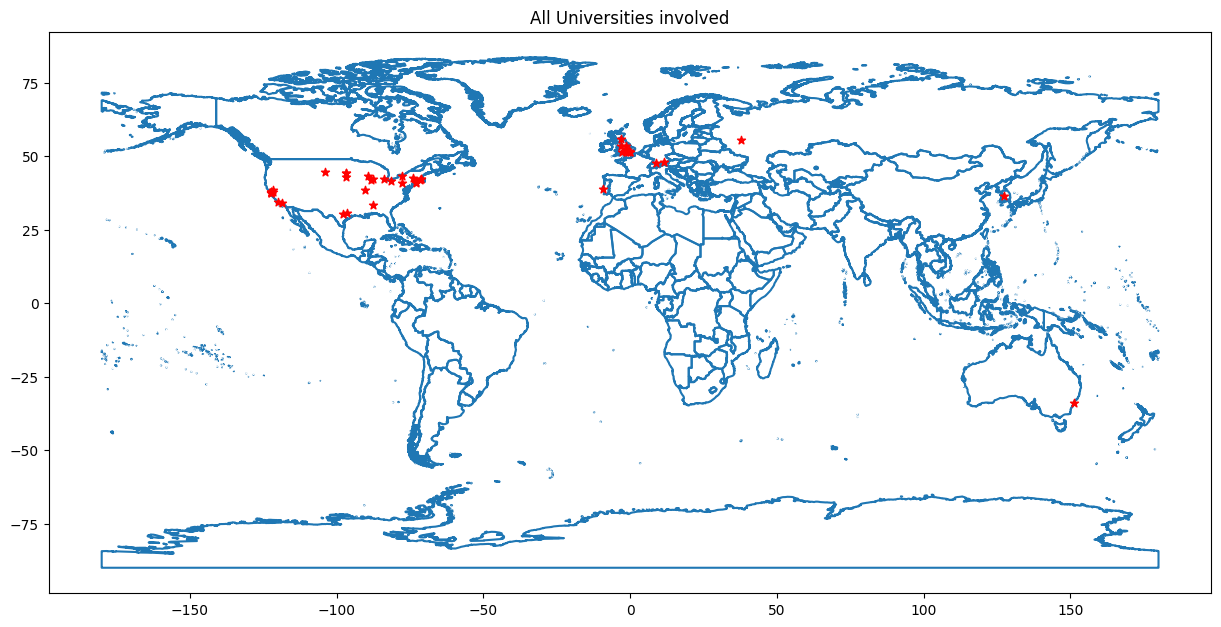

In [39]:
world = gpd.read_file('/home/sam/lz/shps/10m_cultural/ne_10m_admin_0_countries.shp')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

world.boundary.plot(ax=ax, zorder=1) 
ax.scatter(institutions['longitude'],institutions['latitude'], marker='*', color='red', zorder=2)

ax.set_title('All Universities involved')
plt.show()

In [36]:
author_universities = final_info.loc[final_info['isAuthor'] == 'TRUE', 'University'].unique()
author_university_locations = institutions[institutions['University'].isin(author_universities)]

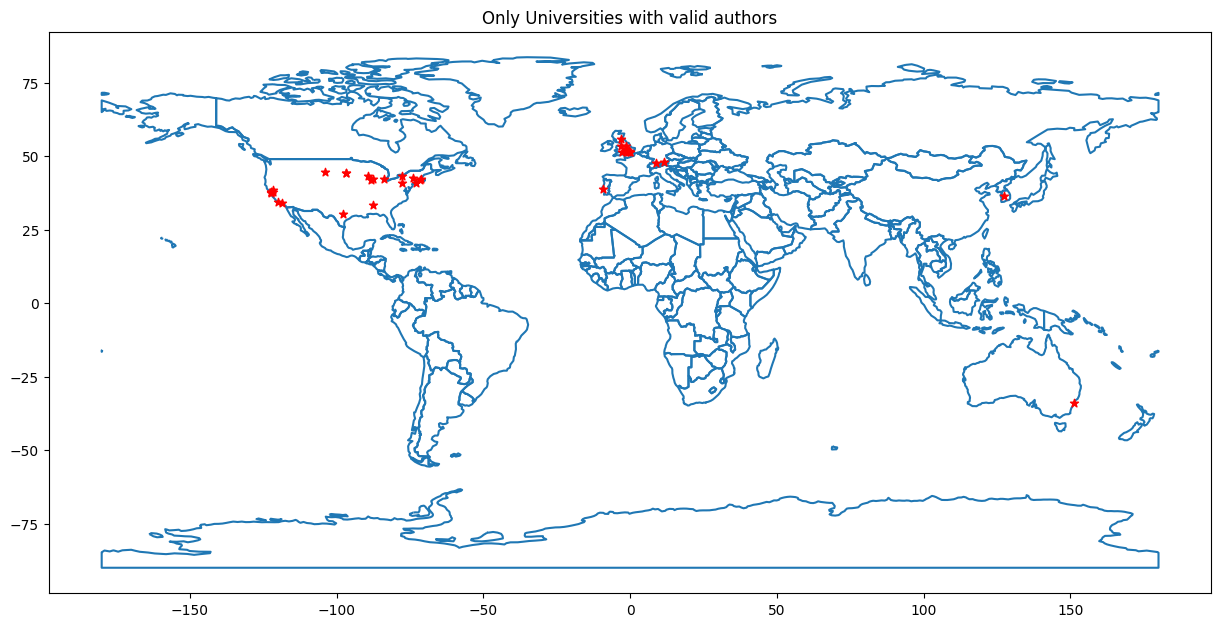

In [49]:
world = gpd.read_file('/home/sam/lz/shps/110m_cultural/ne_110m_admin_0_countries.shp')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

world.boundary.plot(ax=ax, zorder=1) 
ax.scatter(author_university_locations['longitude'],author_university_locations['latitude'], marker='*', color='red', zorder=2)

ax.set_title('Only Universities with valid authors')
plt.show()

Turn into density map

In [128]:
def get_country_or_state(location):
    split_loc = location.split(', ')
    if 'United States' in split_loc:
        try:
            a = int(split_loc[-2])
            binning_region = split_loc[-3]
        except:
            binning_region = split_loc[-2]
    else:
        binning_region = split_loc[-1]
        if 'Svizzera' in binning_region:
            binning_region = 'Switzerland'
    return binning_region

In [135]:
# Calculate number of authors at each university
authors = final_info.loc[final_info['isAuthor'] == 'TRUE']
author_counts = authors['University'].value_counts()
author_university_locations["author_count"] = institutions['University'].map(author_counts)

# Create binning based on either country or state
author_university_locations['Binning1'] = author_university_locations['location'].apply(lambda loc: get_country_or_state(loc.address) if loc else None)

# now recount
author_counts = authors['University'].value_counts()

# Group by 'Binning1' and sum the 'author_count', also removes None - so Korea
grouped_by_country_or_state = author_university_locations.groupby('Binning1').agg({
    'author_count': 'sum',
    'University': 'first', # To make the assumption that everyone flies from one airport in that BinningRegion
    'longitude': 'first',
    'latitude': 'first'
}).reset_index()

grouped_by_country_or_state

/tmp/ipykernel_1190/3077572801.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_university_locations["author_count"] = institutions['University'].map(author_counts)
/tmp/ipykernel_1190/3077572801.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_university_locations['Binning1'] = author_university_locations['location'].apply(lambda loc: get_country_or_state(loc.address) if loc else None)


,Binning1,author_count,University,longitude,latitude
0,Alabama,6.0,University of Alabama,-87.539673,33.212082
1,Australia,1.0,University of Sydney,151.189411,-33.888907
2,California,60.0,Lawrence Berkeley National Laboratory (LBNL),-122.245630,37.876959
3,Deutschland,8.0,University of Maryland,11.582349,48.098982
4,Illinois,3.0,Fermi National Accelerator Laboratory (FNAL),-88.245782,41.842258
5,Massachusetts,2.0,University of Massachusetts,-71.096627,42.358253
6,Michigan,11.0,University of Michigan,-83.710039,42.294214
7,New York,15.0,Brookhaven National Laboratory (BNL),-72.887100,40.864767
8,Pennsylvania,7.0,Pennsylvania State University,-77.855938,40.802583
9,Portugal,7.0,Laboratório de Instrumentação e Física Experim...,-9.143368,38.739920


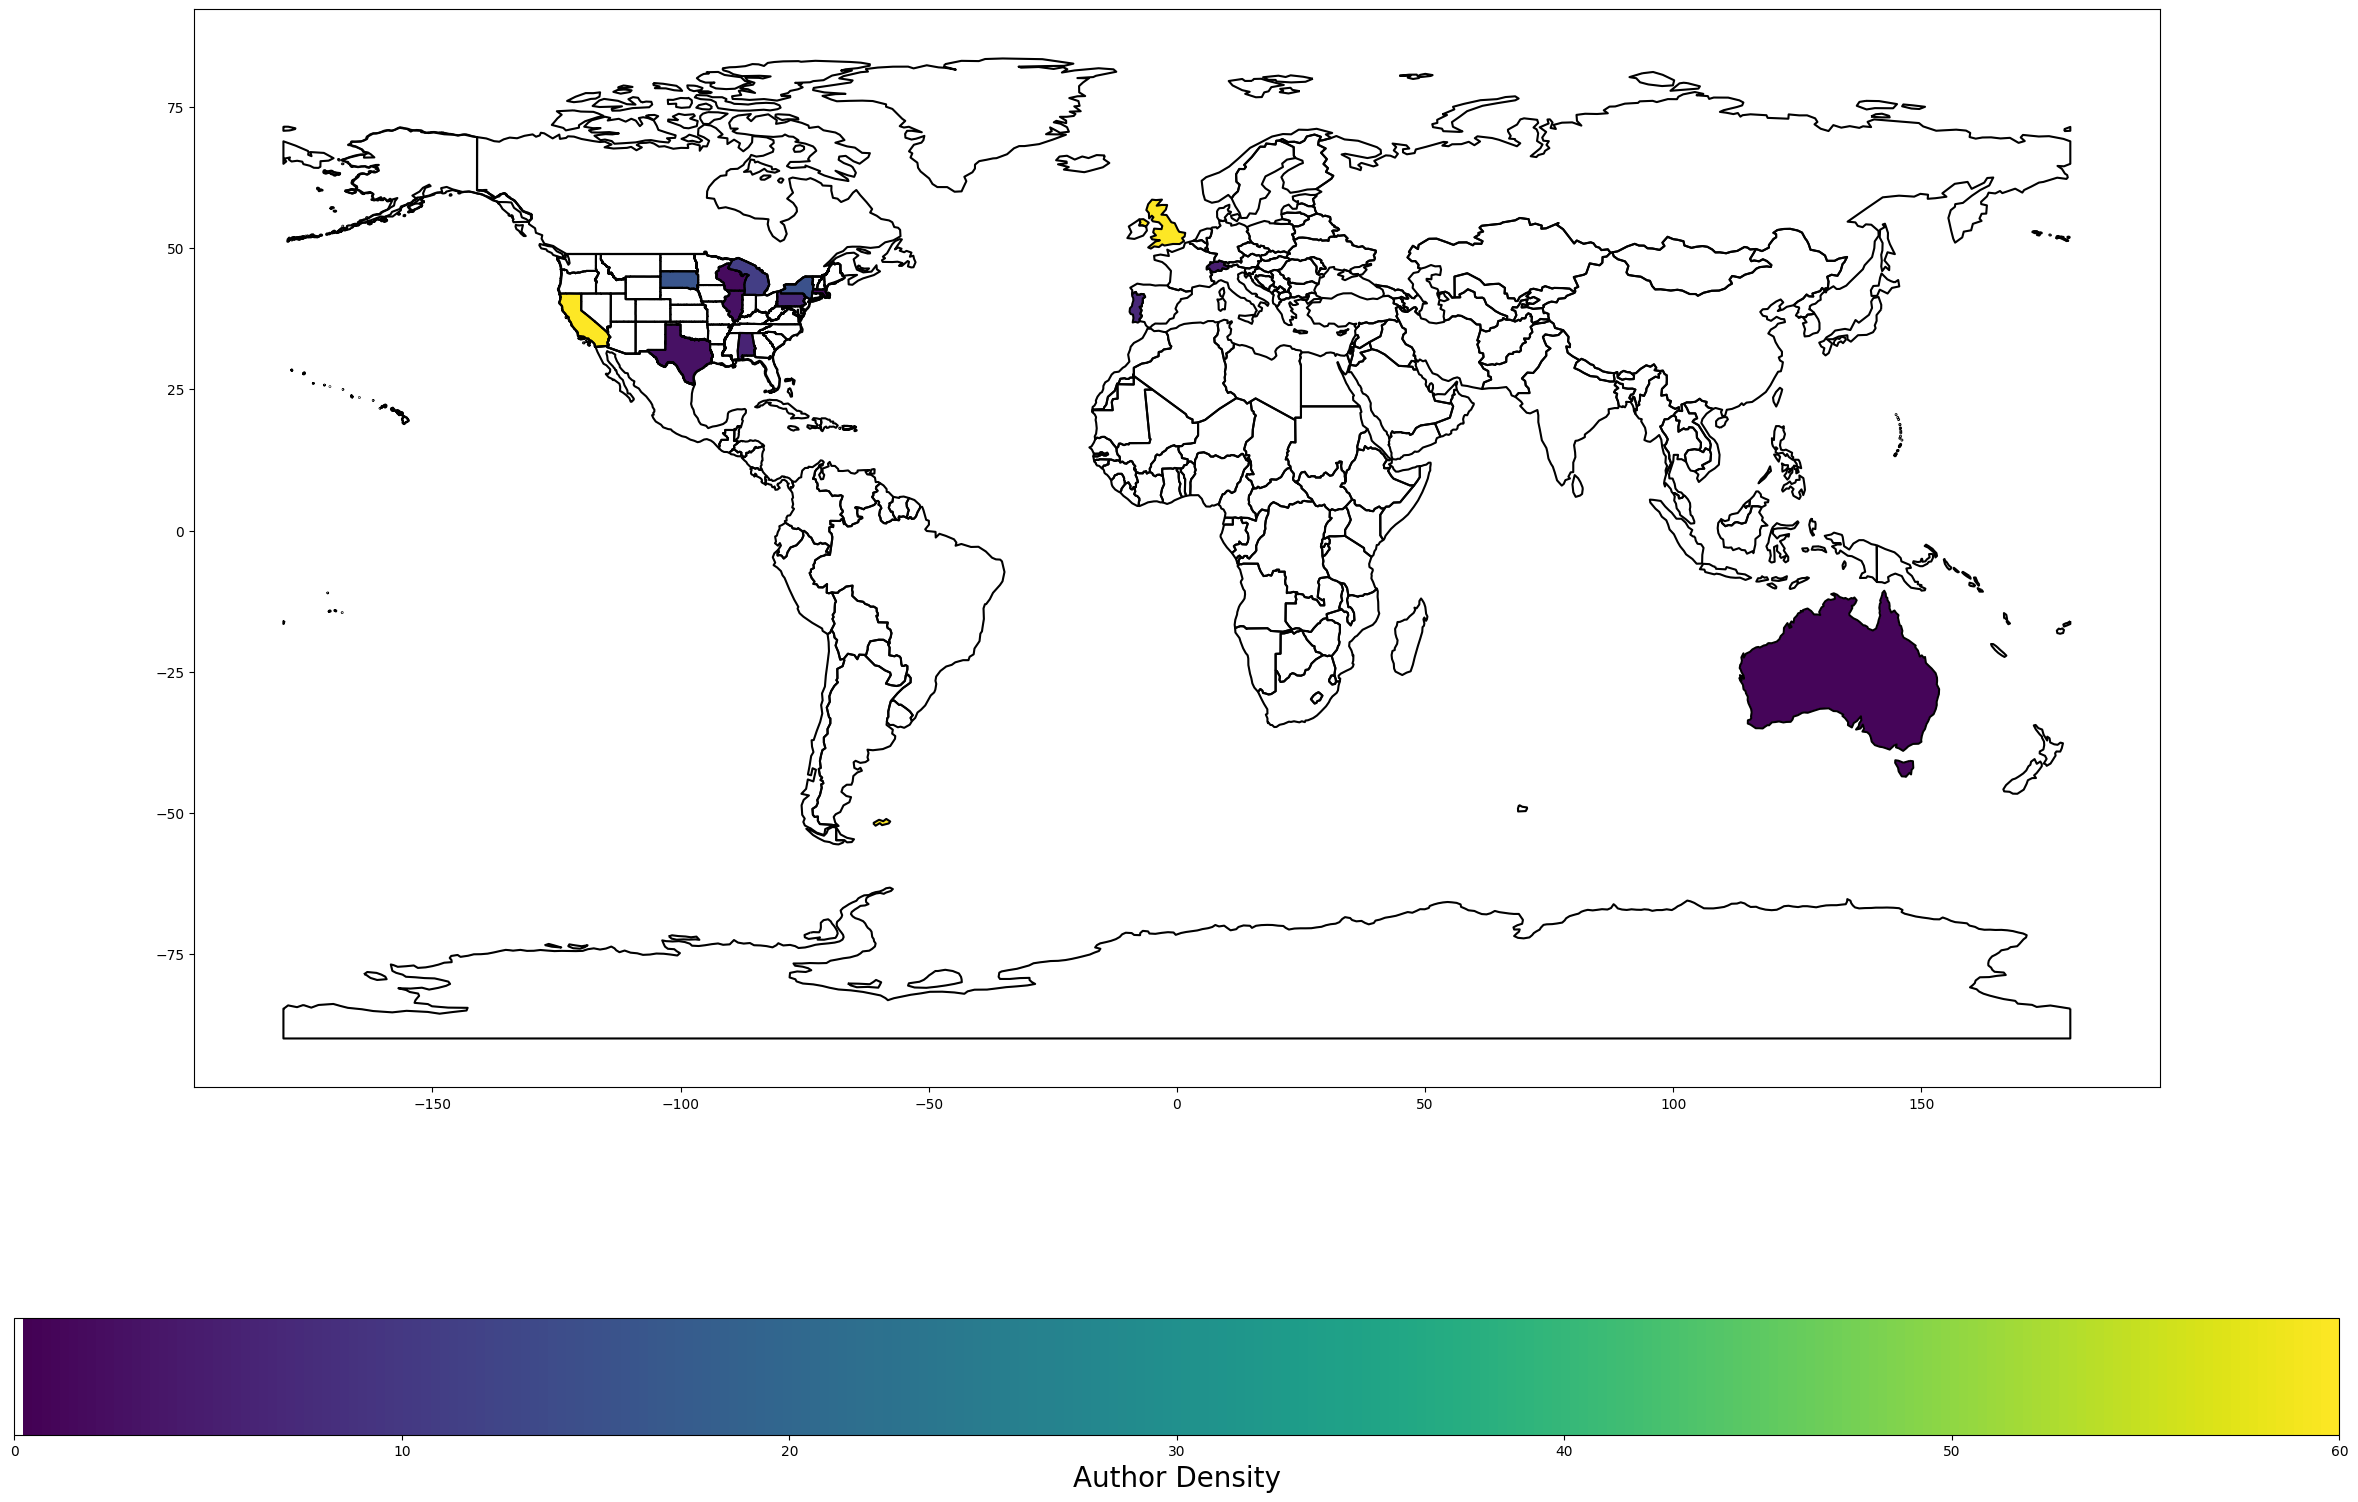

In [134]:
# Load your GeoDataFrames
world = gpd.read_file('/home/sam/lz/shps/110m_cultural/ne_110m_admin_0_countries.shp')
us_states = gpd.read_file('/home/sam/lz/shps/tl_2023_us_state/tl_2023_us_state.shp')

# Add country data
all_countries = world[['SOVEREIGNT', 'geometry']]
all_countries = all_countries.merge(grouped_by_country_or_state, how='left', left_on='SOVEREIGNT', right_on='Binning1')
all_countries['author_count'] = all_countries['author_count'].fillna(0)

# us states
states = us_states[['NAME', 'geometry']]
states = states.merge(grouped_by_country_or_state, how='left', left_on='NAME', right_on='Binning1')

# Define a colormap where the lowest value (0) is white and the rest are colored
cmap = plt.get_cmap('viridis')
cmap = mcolors.ListedColormap(['white'] + [cmap(i) for i in range(cmap.N)])

# Normalize data to ensure non-zero values pop more
norm = mcolors.Normalize(vmin=0, vmax=states['author_count'].max())

fig, ax = plt.subplots(1, 1, figsize=(30, 20))
world.boundary.plot(ax=ax, color='black')
us_states.boundary.plot(ax=ax, color='black')

# Plot the world map with the colormap
all_countries.plot(column='author_count', cmap=cmap, norm=norm, linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)
states.plot(column='author_count', cmap=cmap, norm=norm, linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)

# Add a legend with a distinct color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal')
cbar.set_label('Author Density', fontsize=20)


plt.show()

Find the nearest three airport

In [144]:
import airportsdata
from geopy.distance import great_circle

airports = airportsdata.load('IATA')
airports_df = pd.DataFrame.from_dict(airports, orient='index')

def find_nearest_airports(lat, lon, top_n=3): # assume one of the top 3 is a 'proper airport'
    # Calculate distances and add them as a new column
    airports_df['distance'] = airports_df.apply(
        lambda row: great_circle((lat, lon), (row['lat'], row['lon'])).km,
        axis=1
    )
    
    # Sort the DataFrame by distance
    sorted_airports_df = airports_df.sort_values(by='distance')
    
    # Select the top N nearest airports
    nearest_airports = sorted_airports_df.head(top_n)
    
    return nearest_airports[['iata', 'distance']].values.tolist()

def get_nearest_airports(row):
    return find_nearest_airports(row['latitude'], row['longitude'])

author_aiports_df = grouped_by_country_or_state
author_aiports_df['Airports'] = author_aiports_df.apply(get_nearest_airports, axis=1)

In [147]:
author_aiports_df

,Binning1,author_count,University,longitude,latitude,Airports
0,Alabama,6.0,University of Alabama,-87.539673,33.212082,"[[TCL, 6.739840206642885], [AIV, 62.3161082287..."
1,Australia,1.0,University of Sydney,151.189411,-33.888907,"[[SYD, 6.461845902199614], [BWU, 19.0009039224..."
2,California,60.0,Lawrence Berkeley National Laboratory (LBNL),-122.245630,37.876959,"[[OAK, 17.447245242661477], [CCR, 20.761000720..."
3,Deutschland,8.0,University of Maryland,11.582349,48.098982,"[[OBF, 22.312174397229704], [FEL, 26.227866715..."
4,Illinois,3.0,Fermi National Accelerator Laboratory (FNAL),-88.245782,41.842258,"[[DPA, 7.206869664300017], [AUZ, 20.5968147225..."
5,Massachusetts,2.0,University of Massachusetts,-71.096627,42.358253,"[[BOS, 7.432561088477726], [OWD, 19.6785139514..."
6,Michigan,11.0,University of Michigan,-83.710039,42.294214,"[[ARB, 8.452609719653305], [YIP, 20.2151503857..."
7,New York,15.0,Brookhaven National Laboratory (BNL),-72.887100,40.864767,"[[WSH, 5.054925360438624], [CTO, 8.30466020095..."
8,Pennsylvania,7.0,Pennsylvania State University,-77.855938,40.802583,"[[SCE, 11.809893669336985], [PSB, 21.485859597..."
9,Portugal,7.0,Laboratório de Instrumentação e Física Experim...,-9.143368,38.739920,"[[LIS, 4.646333055204788], [CAT, 18.4518162823..."


In [148]:
import requests

def check_direct_flights(airport_code1, airport_code2, api_key):
    url = f'http://api.aviationstack.com/v1/flights?access_key={api_key}&dep_iata={airport_code1}&arr_iata={airport_code2}'
    response = requests.get(url)
    data = response.json()
    # Check if any flights are found
    if 'data' in data and len(data['data']) > 0:
        return True
    return False

api_key = 'API-KEY'
airport_code1 = 'LHR'
airport_code2 = 'BOS'

has_direct_flights = check_direct_flights(airport_code1, airport_code2, api_key)
print(f"Direct flights from {airport_code1} to {airport_code2}: {'Yes' if has_direct_flights else 'No'}")

Direct flights from LHR to BOS: Yes
